In [1]:
# pwd = "/Users/youtao/code"
pwd = "/scratch/ty296"
hdf5_data_path = '/scratch/ty296/hdf5_data/'
import os
print(os.getcwd())
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
import h5py
import numpy as np

/scratch/ty296


In [2]:
from read_hdf5_func import *

In [3]:
from datetime import date
hdf5_combined_data_path = "/scratch/ty296/hdf5_data_combined"
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.0
combined_sv_filename = os.path.join(hdf5_combined_data_path, f"sv_combined_{p_fixed_name}{p_fixed_value}_{date.today()}.h5")
# combine(combined_sv_filename, p_fixed_name, p_fixed_value)


In [17]:
def fixed_L_threshold_comparison_plot(save_folder: str, L: int, n: int, p_fixed_name: str, p_fixed_value: float, threshold_range: tuple):
    """
    Plot the comparison of the entropy for different thresholds
    """
    
    # Read from csv files
    csv_paths = glob.glob(os.path.join(save_folder, f's{n}_threshold*_{p_fixed_name}{p_fixed_value}.csv'))
    
    # Organize data by threshold values
    plot_data = {}
    import re
    
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        # Find data specific to L
        df_L = df[df['L'] == L]
        
        if len(df_L) == 0:
            continue
            
        # Extract threshold from csv_path filename
        threshold_match = re.search(r'threshold([\d\.e\-\+]+)', csv_path)
        if threshold_match:
            threshold_str = threshold_match.group(1)
            threshold_val = float(threshold_str)
        else:
            continue
            
        # Sort by p_proj and get corresponding values
        sorted_indices = np.argsort(df_L['p_proj'])
        plot_data[threshold_val] = {
            'p_proj': df_L['p_proj'].iloc[sorted_indices].values,
            'mean': df_L['mean'].iloc[sorted_indices].values,
            'sem': df_L['sem'].iloc[sorted_indices].values,
            'variance': df_L['variance'].iloc[sorted_indices].values,
            'se_var': df_L['se_var'].iloc[sorted_indices].values
        }

    # Create plots with same formatting as plot_from_csv
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Get sorted threshold values and create color map
    threshold_values = sorted(plot_data.keys())[threshold_range[0]:threshold_range[1]]
    n_thresholds = len(threshold_values)
    
    # Create increasingly deeper shades of blue proportional to threshold value
    colors = []
    if n_thresholds > 1:
        min_thresh = min(threshold_values)
        max_thresh = max(threshold_values)
        
        for thresh in threshold_values:
            # Normalize threshold to range [0, 1]
            norm_thresh = (thresh - min_thresh) / (max_thresh - min_thresh)
            
            # Create dark blue to light blue gradient
            # Lowest threshold (norm_thresh=0) -> dark blue (0.0, 0.0, 0.8)
            # Highest threshold (norm_thresh=1) -> light blue (0.7, 0.7, 1.0)
            red = 0.7 * norm_thresh            # From 0.0 to 0.7
            green = 0.7 * norm_thresh          # From 0.0 to 0.7  
            blue = 0.8 + 0.2 * norm_thresh     # From 0.8 to 1.0
            
            blue_color = (red, green, blue)
            colors.append(blue_color)
    else:
        colors = [(0.0, 0.0, 0.8)]  # Single dark blue color

    # Plot 1: p_proj vs mean ± sem
    for i, threshold in enumerate(threshold_values):
        data = plot_data[threshold]
        min_ = abs(np.log(sorted(threshold_values, reverse=True)[0]))
        max_ = abs(np.log(min(threshold_values)))
        alpha = (abs(np.log(threshold))-min_)/(max_-min_)
        ax1.errorbar(data['p_proj'], data['mean'], yerr=data['sem'], 
                    label=f'threshold={threshold:.1e}', marker='o', capsize=5, capthick=2, color='blue', alpha=alpha)

        ax2.errorbar(data['p_proj'], data['variance'], yerr=data['se_var'],
                    label=f'threshold={threshold:.1e}', marker='s', capsize=5, capthick=2, color='blue', alpha=alpha)

    ax1.set_xlabel('p_proj')
    ax1.set_ylabel('Mean Entropy ± SEM')
    ax1.set_title(f'Mean Entropy vs p_proj for L={L}')
    ax1.legend()
    # ax1.set_xlim(0.2, 1.0)
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('p_proj')
    ax2.set_ylabel('Variance ± SEVar')
    ax2.set_title(f'Variance vs p_proj for L={L}')
    ax2.legend()
    # ax2.set_xlim(0.2, 1.0)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_folder}/s{n}_threshold_comparison_{L}.png')
    plt.show()
    # plt.close()
    print(f'Threshold comparison for L={L} saved to {save_folder}/s{n}_threshold_comparison_{L}.png')

def plot_from_csv(save_folder, n, threshold: float):
    """
    Plot p_proj vs mean±SEM and p_proj vs variance±SEVAR from CSV file
    CSV should have columns: L, p_ctrl, p_proj, mean, sem, variance, se_var
    """
    # Read CSV data
    csv_path = os.path.join(save_folder, f's{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.csv')
    df = pd.read_csv(csv_path)
    
    # Organize data by L values
    plot_data = {}
    for _, row in df.iterrows():
        L = row['L']
        if L not in plot_data:
            plot_data[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
    
    # Organize data by L values
    plot_data = {}
    for _, row in df.iterrows():
        L = row['L']
        if L not in plot_data:
            plot_data[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
        
        plot_data[L]['p_proj'].append(row['p_proj'])
        plot_data[L]['mean'].append(row['mean'])
        plot_data[L]['sem'].append(row['sem'])
        plot_data[L]['variance'].append(row['variance'])
        plot_data[L]['se_var'].append(row['se_var'])

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Get sorted L values and create color map
    L_values = sorted(plot_data.keys())[0:4]
    n_L = len(L_values)
    
    # Create increasingly deeper shades of blue proportional to L value
    # Smaller L = very light blue, larger L = darker blue
    colors = []
    min_L = min(L_values)
    max_L = max(L_values)
    
    for L in L_values:
        # Normalize L to range [0, 1]
        norm_L = (L - min_L) / (max_L - min_L)
        
        # Create light blue to dark blue gradient
        # Light blue: (0.7, 0.7, 1.0), Dark blue: (0.0, 0.0, 0.8)
        red = 0.7 * (1 - norm_L)      # From 0.7 to 0.0
        green = 0.7 * (1 - norm_L)    # From 0.7 to 0.0  
        blue = 1.0 - 0.2 * norm_L     # From 1.0 to 0.8
        
        blue_color = (red, green, blue)
        
        colors.append(blue_color)

    # Plot 1: p_proj vs mean ± sem
    for i, L in enumerate(L_values):
        data = plot_data[L]
        # Sort by p_proj for cleaner lines
        sorted_indices = np.argsort(data['p_proj'])
        p_proj_sorted = np.array(data['p_proj'])[sorted_indices]
        mean_sorted = np.array(data['mean'])[sorted_indices]
        sem_sorted = np.array(data['sem'])[sorted_indices]
        
        ax1.errorbar(p_proj_sorted, mean_sorted, yerr=sem_sorted, 
                    label=f'L={L}', marker='o', capsize=5, capthick=2, color=colors[i])

    ax1.set_xlabel('p_proj')
    ax1.set_ylabel('Mean Entropy ± SEM')
    ax1.set_title('Mean Entropy vs p_proj for Different L')
    ax1.legend()
    ax1.set_xlim(0.2, 1.0)
    ax1.grid(True, alpha=0.3)

    # Plot 2: p_proj vs variance ± se_var
    for i, L in enumerate(L_values):
        data = plot_data[L]
        # Sort by p_proj for cleaner lines
        sorted_indices = np.argsort(data['p_proj'])
        p_proj_sorted = np.array(data['p_proj'])[sorted_indices]
        variance_sorted = np.array(data['variance'])[sorted_indices]
        se_var_sorted = np.array(data['se_var'])[sorted_indices]
        
        ax2.errorbar(p_proj_sorted, variance_sorted, yerr=se_var_sorted, 
                    label=f'L={L}', marker='s', capsize=5, capthick=2, color=colors[i])

    ax2.set_xlabel('p_proj')
    ax2.set_ylabel('Variance ± SEVar')
    ax2.set_title('Variance vs p_proj for Different L')
    ax2.legend()
    ax2.set_xlim(0.2, 1.0)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_folder}/s{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.png')
    plt.close()
    print(f'threshold {threshold} saved to {save_folder}/s{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.png')
    # plt.show()

In [ ]:
# n = 0
# from read_hdf5_func import h5_to_csv
# for threshold_val in np.logspace(-15, -5, 10):
#     h5_to_csv(combined_sv_filename, n, threshold_val, p_fixed_name, p_fixed_value)

In [6]:
# save_folder = "/scratch/ty296/plots"
# for threshold_val in np.logspace(-15, -5, 10):
#     plot_from_csv(save_folder, n, threshold_val)

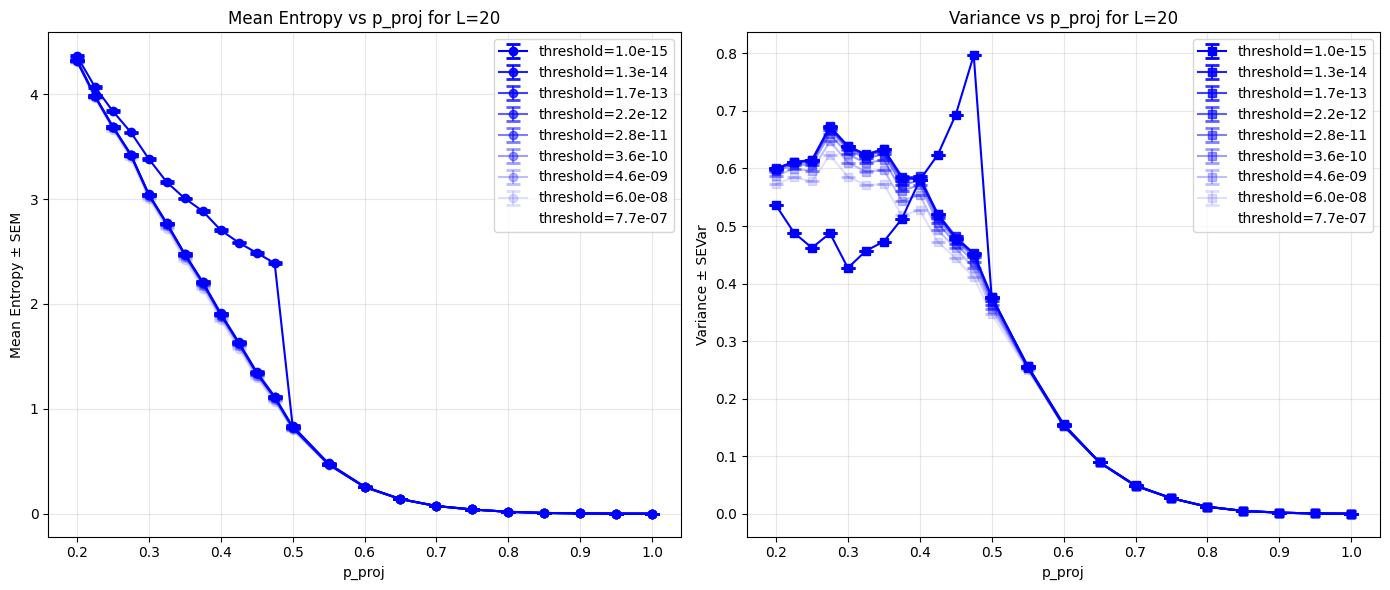

Threshold comparison for L=20 saved to /scratch/ty296/plots/s0_threshold_comparison_20.png


In [19]:
L_target = 20
n_thresholds = 9
i = 0
n = 0
fixed_L_threshold_comparison_plot("/scratch/ty296/plots", L_target, n, p_fixed_name, p_fixed_value, (i, i+n_thresholds))

In [8]:
# plot distributions
L_target = 20
threshold_val = 1e-10
min_sv_dict, maxbond_dict, entropy_dict = distribution_dict(combined_sv_filename, L_target, threshold_val)

INVALID MIN_SV (skipping): seed=0
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=100
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=101
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=107
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=11
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=110
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=113
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=114
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=115
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=117
  Parameters: L=20, p_ctrl=0.0, p_proj=0.225
  min_sv valu

/scratch/ty296/CT_MPS_mini/read_hdf5_func.py:363: RuntimeWarning: divide by zero encountered in log
  SvN = np.log(len(sv_arr))


INVALID MIN_SV (skipping): seed=647
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=65
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=651
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=655
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=661
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=662
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=663
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=670
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=671
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=672
  Parameters: L=20, p_ctrl=0.0, p_proj=0.25
  min_sv value: 0.0
I

(20, 0.0, 0.2) 715
(20, 0.0, 0.225) 699
(20, 0.0, 0.25) 642
(20, 0.0, 0.275) 614
(20, 0.0, 0.3) 564
(20, 0.0, 0.325) 562
(20, 0.0, 0.35) 526
(20, 0.0, 0.375) 561
(20, 0.0, 0.4) 520
(20, 0.0, 0.425) 499
(20, 0.0, 0.44999999999999996) 480
(20, 0.0, 0.475) 497
(20, 0.0, 0.5) 511
(20, 0.0, 0.55) 555
(20, 0.0, 0.6) 664
(20, 0.0, 0.65) 750
(20, 0.0, 0.7) 836
(20, 0.0, 0.75) 906
(20, 0.0, 0.8) 942
(20, 0.0, 0.85) 976
(20, 0.0, 0.9) 985
(20, 0.0, 0.95) 995
(20, 0.0, 1.0) 1000


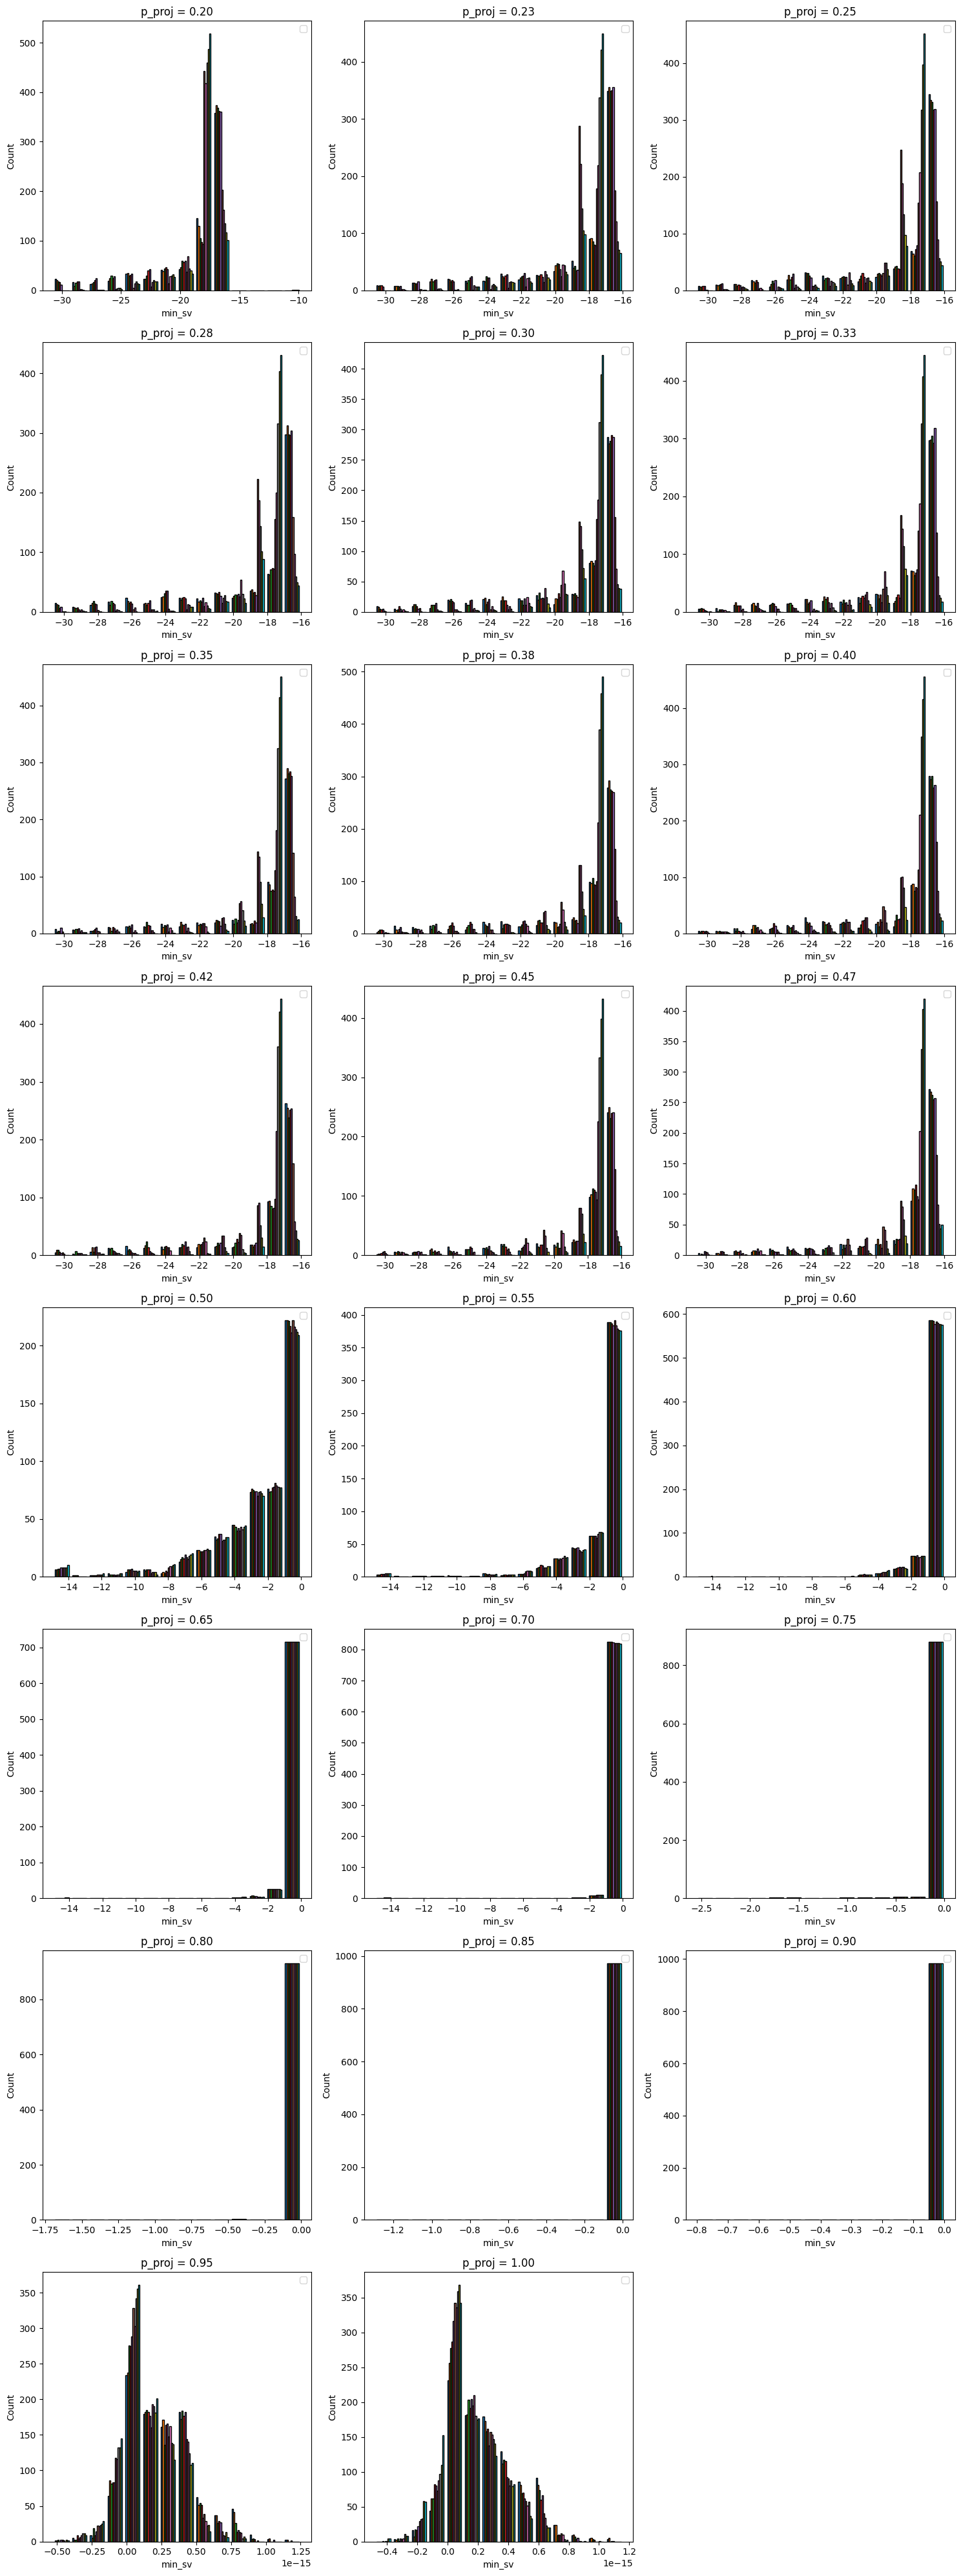

In [16]:
plot_distribution(min_sv_dict, x_label='min_sv', log_scale=True, n_bins=14)


(20, 0.0, 0.2) 976
(20, 0.0, 0.225) 957
(20, 0.0, 0.25) 929
(20, 0.0, 0.275) 914
(20, 0.0, 0.3) 907
(20, 0.0, 0.325) 916
(20, 0.0, 0.35) 929
(20, 0.0, 0.375) 937
(20, 0.0, 0.4) 949
(20, 0.0, 0.425) 960
(20, 0.0, 0.44999999999999996) 971
(20, 0.0, 0.475) 983
(20, 0.0, 0.5) 1000
(20, 0.0, 0.55) 1000
(20, 0.0, 0.6) 1000
(20, 0.0, 0.65) 1000
(20, 0.0, 0.7) 1000
(20, 0.0, 0.75) 1000
(20, 0.0, 0.8) 1000
(20, 0.0, 0.85) 1000
(20, 0.0, 0.9) 1000
(20, 0.0, 0.95) 1000
(20, 0.0, 1.0) 1000


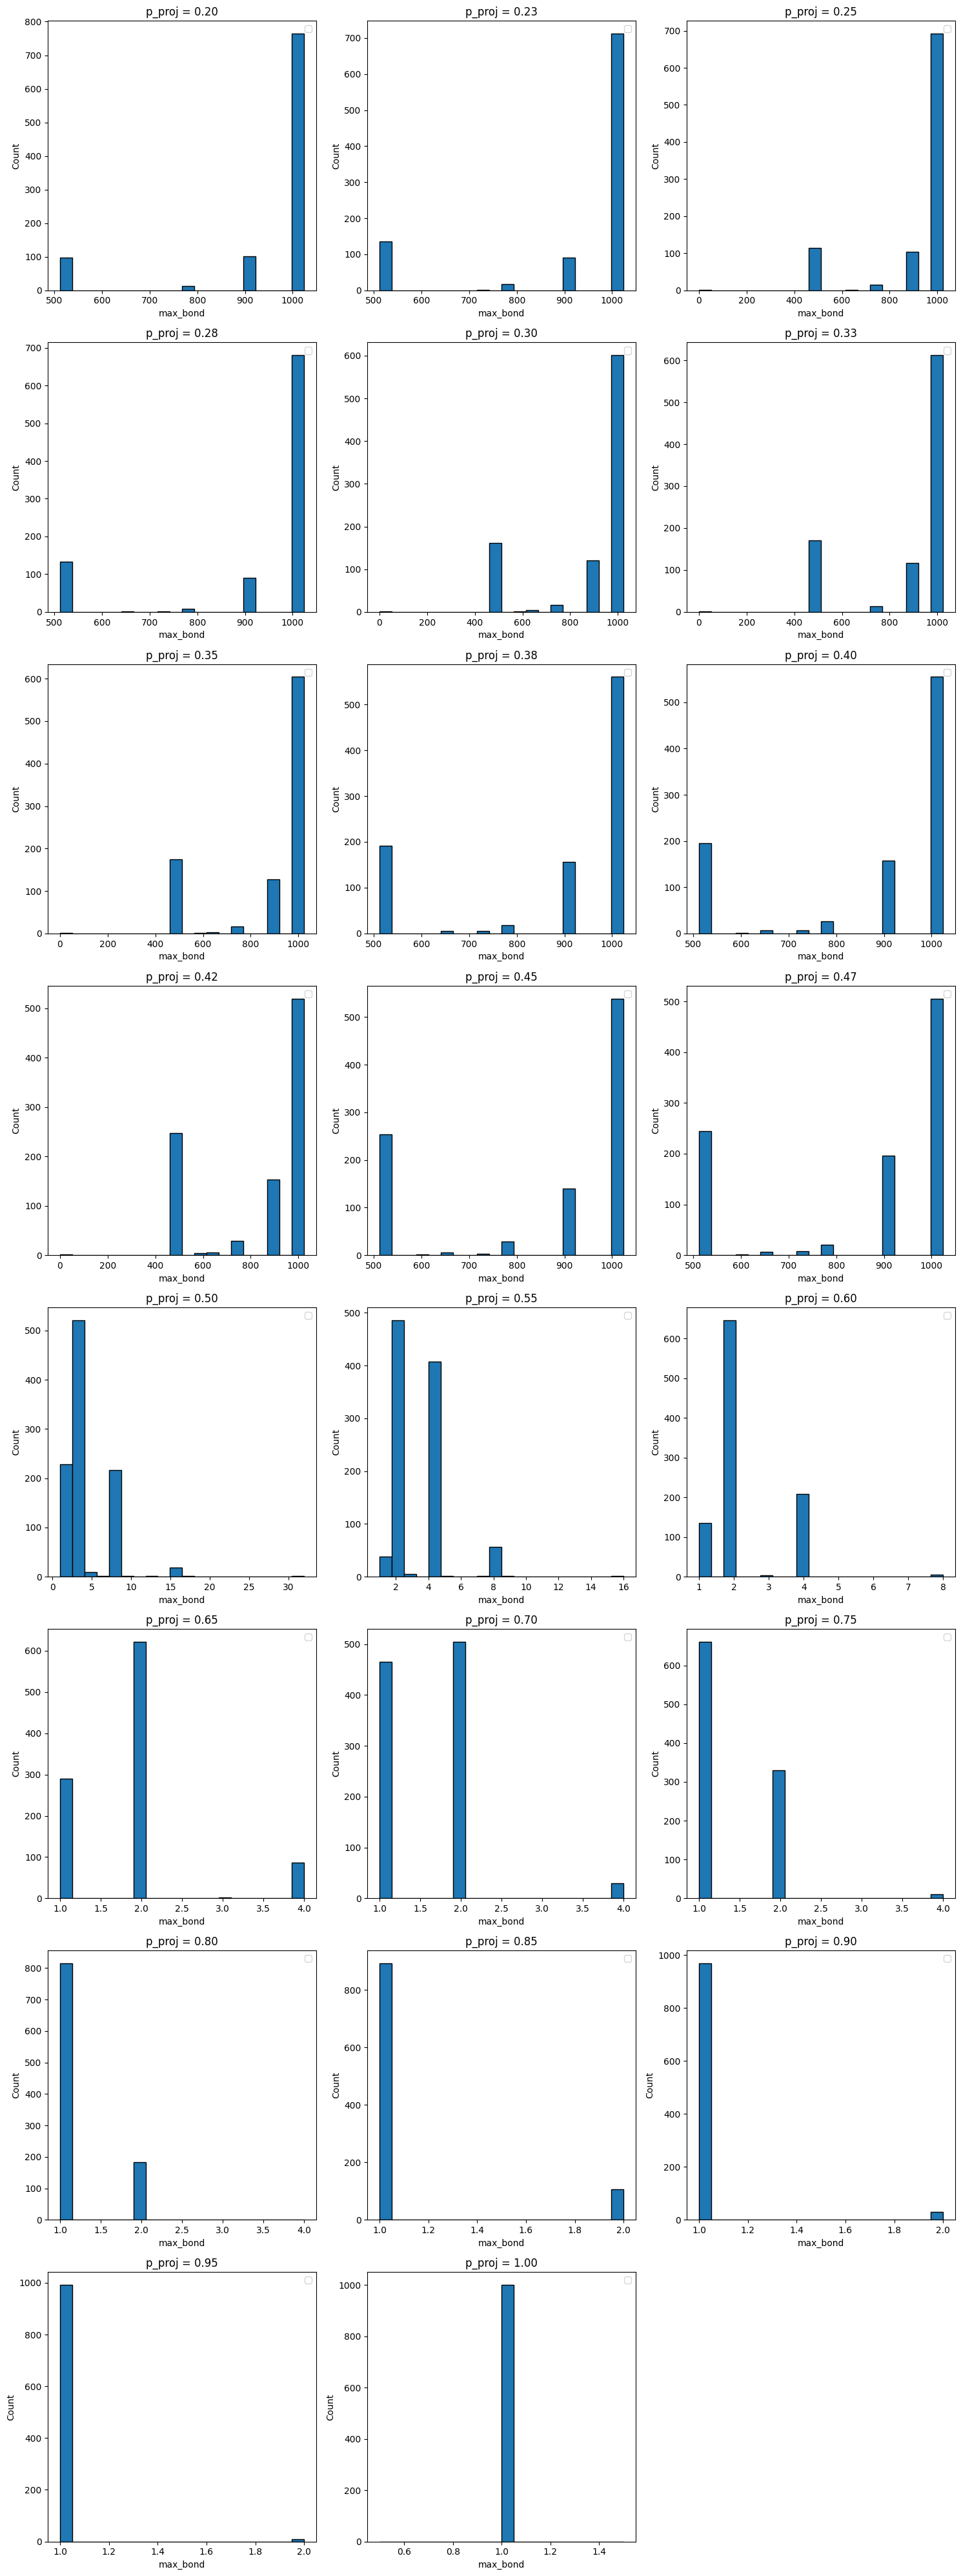

In [13]:
plot_distribution(maxbond_dict, x_label='max_bond')


In [14]:
len(entropy_dict)

23

(20, 0.0, 0.2) 715
(20, 0.0, 0.225) 699
(20, 0.0, 0.25) 642
(20, 0.0, 0.275) 614
(20, 0.0, 0.3) 564
(20, 0.0, 0.325) 562
(20, 0.0, 0.35) 526
(20, 0.0, 0.375) 561
(20, 0.0, 0.4) 520
(20, 0.0, 0.425) 499
(20, 0.0, 0.44999999999999996) 480
(20, 0.0, 0.475) 497
(20, 0.0, 0.5) 511
(20, 0.0, 0.55) 555
(20, 0.0, 0.6) 664
(20, 0.0, 0.65) 750
(20, 0.0, 0.7) 836
(20, 0.0, 0.75) 906
(20, 0.0, 0.8) 942
(20, 0.0, 0.85) 976
(20, 0.0, 0.9) 985
(20, 0.0, 0.95) 995
(20, 0.0, 1.0) 1000


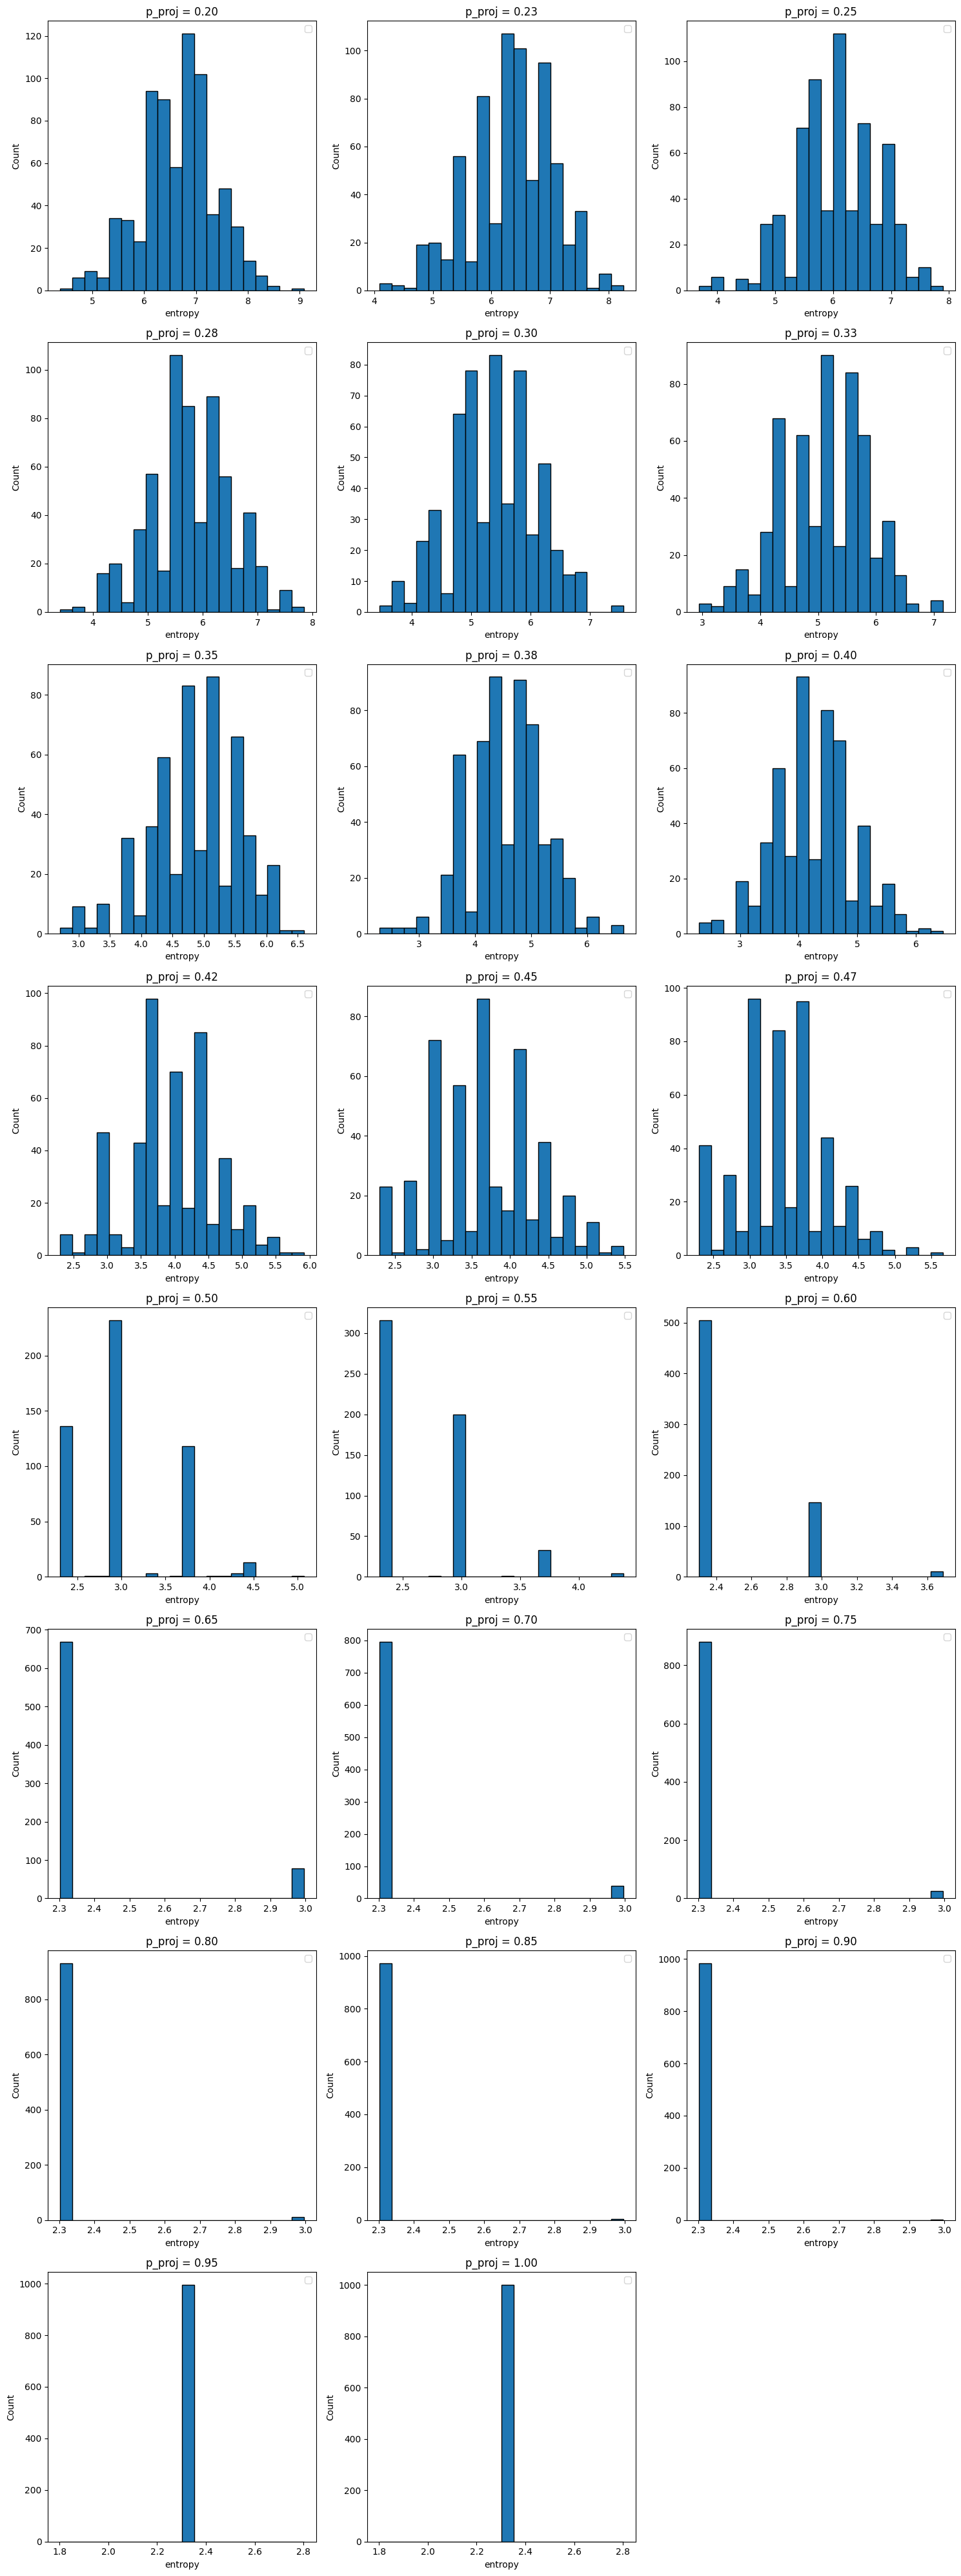

In [15]:
plot_distribution(entropy_dict, x_label='entropy')


In [ ]:
# Alternative plotting function with more flexibility
def plot_entropy_analysis(data_dict, save_folder='/scratch/ty296/CT_MPS_mini/plots'):
    """
    Create comprehensive entropy analysis plots from dictionary
    data_dict format: {(L, p_ctrl, p_proj): (mean, sem, var, semvar)}
    
    Creates multiple plots:
    1. Mean entropy vs p_proj for different L values (fixed p_ctrl)
    2. Variance vs p_proj for different L values (fixed p_ctrl)  
    3. Mean entropy vs p_ctrl for different L values (fixed p_proj)
    4. Variance vs p_ctrl for different L values (fixed p_proj)
    """
    import os
    import numpy as np
    
    # Create save folder if it doesn't exist
    os.makedirs(save_folder, exist_ok=True)
    
    # Extract unique values
    L_values = sorted(set(key[0] for key in data_dict.keys()))
    p_ctrl_values = sorted(set(key[1] for key in data_dict.keys()))
    p_proj_values = sorted(set(key[2] for key in data_dict.keys()))
    
    print(f"Found L values: {L_values}")
    print(f"Found p_ctrl values: {p_ctrl_values}")
    print(f"Found p_proj values: {p_proj_values}")
    
    # Color scheme for L values
    def get_colors(values):
        colors = []
        if len(values) > 1:
            min_val = min(values)
            max_val = max(values)
            
            for val in values:
                # Normalize to range [0, 1]
                norm_val = (val - min_val) / (max_val - min_val)
                
                # Create light blue to dark blue gradient
                red = 0.7 * (1 - norm_val)      # From 0.7 to 0.0
                green = 0.7 * (1 - norm_val)    # From 0.7 to 0.0  
                blue = 1.0 - 0.2 * norm_val     # From 1.0 to 0.8
                
                colors.append((red, green, blue))
        else:
            colors = [(0.0, 0.0, 0.8)]  # Single dark blue color
        return colors
    
    colors = get_colors(L_values)
    
    # Plot 1 & 2: vs p_proj for different L (fix p_ctrl to middle value)
    if len(p_ctrl_values) > 0:
        p_ctrl_fixed = p_ctrl_values[len(p_ctrl_values)//2]  # Use middle value
        
        # Organize data by L
        plot_data_pproj = {}
        for (L, p_ctrl, p_proj), (mean, sem, var, semvar) in data_dict.items():
            if p_ctrl == p_ctrl_fixed:
                if L not in plot_data_pproj:
                    plot_data_pproj[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
                
                plot_data_pproj[L]['p_proj'].append(p_proj)
                plot_data_pproj[L]['mean'].append(mean)
                plot_data_pproj[L]['sem'].append(sem)
                plot_data_pproj[L]['variance'].append(var)
                plot_data_pproj[L]['se_var'].append(semvar)
        
        if plot_data_pproj:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Plot mean vs p_proj
            for i, L in enumerate(sorted(plot_data_pproj.keys())):
                data = plot_data_pproj[L]
                sorted_indices = np.argsort(data['p_proj'])
                x_sorted = np.array(data['p_proj'])[sorted_indices]
                mean_sorted = np.array(data['mean'])[sorted_indices]
                sem_sorted = np.array(data['sem'])[sorted_indices]
                
                color_idx = L_values.index(L) if L in L_values else 0
                ax1.errorbar(x_sorted, mean_sorted, yerr=sem_sorted, 
                            label=f'L={L}', marker='o', capsize=5, capthick=2, 
                            color=colors[color_idx])
            
            ax1.set_xlabel('p_proj')
            ax1.set_ylabel('Mean Entropy ± SEM')
            ax1.set_title(f'Mean Entropy vs p_proj (p_ctrl={p_ctrl_fixed})')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot variance vs p_proj
            for i, L in enumerate(sorted(plot_data_pproj.keys())):
                data = plot_data_pproj[L]
                sorted_indices = np.argsort(data['p_proj'])
                x_sorted = np.array(data['p_proj'])[sorted_indices]
                var_sorted = np.array(data['variance'])[sorted_indices]
                se_var_sorted = np.array(data['se_var'])[sorted_indices]
                
                color_idx = L_values.index(L) if L in L_values else 0
                ax2.errorbar(x_sorted, var_sorted, yerr=se_var_sorted, 
                            label=f'L={L}', marker='s', capsize=5, capthick=2, 
                            color=colors[color_idx])
            
            ax2.set_xlabel('p_proj')
            ax2.set_ylabel('Variance ± SEVar')
            ax2.set_title(f'Variance vs p_proj (p_ctrl={p_ctrl_fixed})')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            save_path = os.path.join(save_folder, f'entropy_vs_pproj_pctrl{p_ctrl_fixed}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Plot saved to {save_path}')
            plt.show()
    
    # Plot 3 & 4: vs p_ctrl for different L (fix p_proj to middle value)
    if len(p_proj_values) > 0:
        p_proj_fixed = p_proj_values[len(p_proj_values)//2]  # Use middle value
        
        # Organize data by L
        plot_data_pctrl = {}
        for (L, p_ctrl, p_proj), (mean, sem, var, semvar) in data_dict.items():
            if p_proj == p_proj_fixed:
                if L not in plot_data_pctrl:
                    plot_data_pctrl[L] = {'p_ctrl': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
                
                plot_data_pctrl[L]['p_ctrl'].append(p_ctrl)
                plot_data_pctrl[L]['mean'].append(mean)
                plot_data_pctrl[L]['sem'].append(sem)
                plot_data_pctrl[L]['variance'].append(var)
                plot_data_pctrl[L]['se_var'].append(semvar)
        
        if plot_data_pctrl:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Plot mean vs p_ctrl
            for i, L in enumerate(sorted(plot_data_pctrl.keys())):
                data = plot_data_pctrl[L]
                sorted_indices = np.argsort(data['p_ctrl'])
                x_sorted = np.array(data['p_ctrl'])[sorted_indices]
                mean_sorted = np.array(data['mean'])[sorted_indices]
                sem_sorted = np.array(data['sem'])[sorted_indices]
                
                color_idx = L_values.index(L) if L in L_values else 0
                ax1.errorbar(x_sorted, mean_sorted, yerr=sem_sorted, 
                            label=f'L={L}', marker='o', capsize=5, capthick=2, 
                            color=colors[color_idx])
            
            ax1.set_xlabel('p_ctrl')
            ax1.set_ylabel('Mean Entropy ± SEM')
            ax1.set_title(f'Mean Entropy vs p_ctrl (p_proj={p_proj_fixed})')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot variance vs p_ctrl
            for i, L in enumerate(sorted(plot_data_pctrl.keys())):
                data = plot_data_pctrl[L]
                sorted_indices = np.argsort(data['p_ctrl'])
                x_sorted = np.array(data['p_ctrl'])[sorted_indices]
                var_sorted = np.array(data['variance'])[sorted_indices]
                se_var_sorted = np.array(data['se_var'])[sorted_indices]
                
                color_idx = L_values.index(L) if L in L_values else 0
                ax2.errorbar(x_sorted, var_sorted, yerr=se_var_sorted, 
                            label=f'L={L}', marker='s', capsize=5, capthick=2, 
                            color=colors[color_idx])
            
            ax2.set_xlabel('p_ctrl')
            ax2.set_ylabel('Variance ± SEVar')
            ax2.set_title(f'Variance vs p_ctrl (p_proj={p_proj_fixed})')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            save_path = os.path.join(save_folder, f'entropy_vs_pctrl_pproj{p_proj_fixed}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Plot saved to {save_path}')
            plt.show()

# Run the comprehensive analysis
plot_entropy_analysis(plot_dict)
